# Adult income classification

In the following notebook we'll be using the "Adult" dataset. This dataset contains a binary label indicating if a person's annual income is larger than $50k per year. The data is available on the [UCI machine learning repository](https://archive.ics.uci.edu/ml/index.php).

In [2]:
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
names = [
    'age', 'workclass', 'fnlwgt', 'education',
    'education-num', 'marital-status', 'occupation',
    'relationship', 'race', 'gender', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country',
    'salary'
]
dtypes = {
    'workclass': 'category',
    'education': 'category',
    'marital-status': 'category',
    'occupation': 'category',
    'relationship': 'category',
    'race': 'category',
    'gender': 'category',
    'native-country': 'category'
}

X = pd.read_csv(url, names=names, header=None, dtype=dtypes)
y = X.pop('salary').map({' <=50K': False, ' >50K': True})

X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


`ethik` analyzes a model based on the predictions it makes on a test set. Consequently we first have to split our dataset in two.

In [3]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, shuffle=True, random_state=42)

We will now train a model using [LightGBM](https://lightgbm.readthedocs.io/en/latest/).

In [4]:
import lightgbm as lgb

model = lgb.LGBMClassifier(random_state=42).fit(X_train, y_train)

We can now make predictions for the test set. We'll use a variable named `y_pred` to store the predicted probabilities associated with the `True` label.

In [5]:
y_pred = model.predict_proba(X_test)[:, 1]

We can now fit an `Explainer` using the features from the test set. This will analyze the distribution of each feature and build a set of `lambda` coefficients which can be used to explain model predictions.

In [6]:
import ethik

explainer = ethik.Explainer()
%time explainer = explainer.fit(X_test)

CPU times: user 63.3 ms, sys: 103 ms, total: 166 ms
Wall time: 10.9 s


## Understanding model predictions

We can start by looking at how the probability of having a higher income changes with respect to the `education-num` variable, **as perceived by the model**.

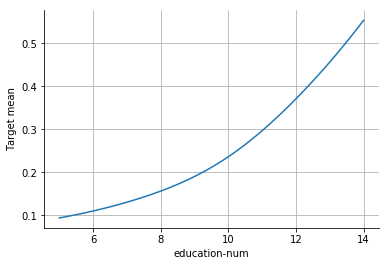

In [7]:
ax = explainer.plot_predictions(
    X=X_test['education-num'],
    y_pred=y_pred
)

Clearly we see that the model believes that the probability of having a salary above $50k increases with the amount of education. Although this might seem like an obvious statement, it's good to confirm that the model is seeing it. Moreover, it's helpful to be able to quantify by how much the model changes it's predictions.

We can also plot the distribution of predictions for more than one variable. However, because different variables have different scales we have to use a common measure to display them together. For this purpose we plot the τ ("tau") values. These values are contained between -1 and 1 and simply reflect by how much the variable is shifted from it's mean towards it's lower and upper quantiles. In the following figure a tau value of -1 corresponds to just under 20 years old whereas a tau value of 1 refers to being slightly over 60 years old.

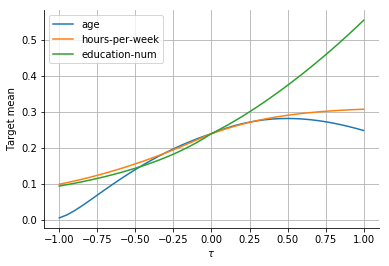

In [8]:
ax = explainer.plot_predictions(
    X=X_test[['age', 'hours-per-week', 'education-num']],
    y_pred=y_pred
)

One of the uses of these kinds of plots is to see if variables affect the outcome on average or not. Indeed, the straighter the lines, the less the associated variable has an impact on the average outcome. This is very handy to know if said variable is, say, a social trait such as the ethinicity and the target is a credit score. In this case, `ethik` can be used to visualize and quantify the bias of the model with respect to the social trait.

## Evaluating model reliability

`ethik` can also be used to assess the reliability of a model with respect to a variable. Let us first evaluate the global performance of our model.

In [9]:
from sklearn import metrics

print(f'Accuracy score: {metrics.accuracy_score(y_test, y_pred > 0.5):.4f}')

Accuracy score: 0.8788


With `ethik` we can see how performant the model with respect to a variable, for example `age`.

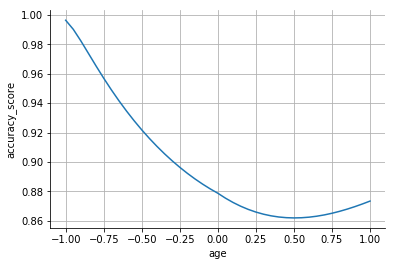

In [13]:
ax = explainer.plot_metric(
    X=X_test['age'],
    y=y_test,
    y_pred=y_pred > 0.5,
    metric=metrics.accuracy_score
)

We can see that although the overall accuracy is around 0.88, it is much higher when the age is lower. This is quite intuitive, as we can imagine that young adults more often than not have a salary under $50k. When they get older, many things can happen and their salary isn't as easy to guess, which translates to a lower model accuracy.

In the same way as before, we can visualize the performance of the metric with respect to multiple variables. 

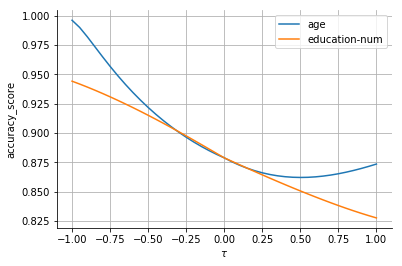

In [14]:
ax = explainer.plot_metric(
    X=X_test[['age', 'education-num']],
    y=y_test,
    y_pred=y_pred > 0.5,
    metric=metrics.accuracy_score
)

These kind of reliability plots can be used for many cases. For example, now that we know the model is less accurate for older people than young ones, we might want to focus our data analysis on older people in order to extract helpful features. `ethik` can thus help guide a data science project by telling you where your model is failing to perform.  